# Full massplanes

**Goal:** It's nice to also have the version of this plot that includes more of the massplane region and also shows the region(s) for:
(1) The reweighting derivation
(2) The interpolation training.

I think I'll want to include 3 plots for this:
1. The rev $\Delta \eta_{HH}$ region
2. The 4b massplane (but with the shifted regions definitions included)
3. The 3b1f region.

Maybe I'll make the shifted region plot first since this will (maybe) be helpful for setting the same range for the other plots?

In [1]:
import uproot
import pandas as pd
import numpy as np
from scipy.stats import chisquare, kstest, entropy

import matplotlib.pyplot as plt
import os
os.sys.path += ['../PyATLASstyle/','../../hh4b/hh4b-plots/','../gp-for-flows/'] 

# Let's do ATLAS style plots too!
import matplotlib as mpl
import PyATLASstyle as pas
pas.applyATLASstyle(mpl)

from hh4b_plots.colors import *
from hh4b_plots.phys_utils import get_lumi
from hh4b_plots.hh4b_plots import draw_contours
from hh4b_plots.regions import get_reg_fn

from matplotlib.colors import LogNorm


%load_ext autoreload
%autoreload 2

Using uproot4


**Setup** These flags let me toggle which validation region we're looking at / which plot we're making.

In [2]:
val_region = '4b'

**Step 1:** Load in the files

In [3]:
load_cols = ['m_h1','m_h2','ntag','minQ','pass_vbf_sel'] # X_wt_tag
yrs = ['16','17','18']

x,y = 124,117 
res_x, res_y = 0.1, 0.1
    
rev_deta = False
fDir = '../data/RR/NR-UNBLIND-FEB22-1'
fnames = [f'{fDir}/data{yr}.root' for yr in yrs]

if val_region == 'rev_deta':

    fDir = '../data/RR/cryptotuples/rev_deta/'
    fnames = [f'{fDir}/data_rev_deta_{yr}.root' for yr in yrs]

    rev_deta = True
    subDir = 'data161718-MAY21_4b_rev_deta_ggf'

    region_tag = "\n4b, rev $\Delta \eta_{HH}$ SR"

elif (val_region == '3b1f') or (val_region == '4b'):

    subDir = f'data161718-MAY21_{val_region}_detaCut_ggf'
    region_tag = f"\n{val_region} region"
    
else: 
    raise NotImplementedError

In [4]:
val_region

'4b'

In [5]:
dfs = []

for yr, fname in zip(yrs,fnames):

    print(fname)
    with uproot.open(fname) as f:

        dfi = f['fullmassplane'].arrays(load_cols,library='pd')

        # GP non-closures
        if val_region == '3b1f':
            m_4b = dfi.eval(f'ntag ==3 & minQ == 1 & ~pass_vbf_sel')
        else:
            m_4b = dfi.eval(f'ntag >=4 & ~pass_vbf_sel')
           
        dfs.append(dfi)
        
df = pd.concat(dfs)

../data/RR/NR-UNBLIND-FEB22-1/data16.root
../data/RR/NR-UNBLIND-FEB22-1/data17.root
../data/RR/NR-UNBLIND-FEB22-1/data18.root


In [7]:
len(dfs)

3

**Step 2:** Draw the plot

For the std massplane plots that we put in the paper, we had **50** bins from (50, 200) and the y-axis was labeled: "Entries / (3 GeV)^2"


**Below:** Some fcts that I grabbed for hh4b-plots.

In [6]:
nbins = 50
r = (25,225)

w = (r[1] - r[0]) / nbins
zlabel = f'Entries / ({int(w)} GeV)$^2$'


In [7]:
zlabel

'Entries / (4 GeV)$^2$'

In [8]:
lw = 3

In [9]:
reg_dict = {
        "SR": {
            "fn": "Xhh",
            "fn_args": {"center_x": 124, "center_y": 117, "res": 0.1},
            "bound": 1.6,
            "color": "hh:darkpink",
            "lw": lw,
            "ls": "solid",
            "label": "SR",
        },
        "CR": {
            "fn": "CVR_q",
            "fn_args": {
                "center_x": 124,
                "center_y": 117,
                "delta": 0.05,
                "angle": np.pi / 4.0,
                "qs": [0, 3],
            },
            "bound": 1,
            "color": 'hh:darkblue', #"hh:medturquoise",
            "lw": lw,
            "ls": "dashed",
            "label": "rw CR",
        },
        # "VR": {
        #     "fn": "CVR_q",
        #     "fn_args": {
        #         "center_x": 124,
        #         "center_y": 117,
        #         "delta": 0.05,
        #         "angle": np.pi / 4.0,
        #         "qs": [1, 2],
        #     },
        #     "bound": 1,
        #     "color": "hh:medturquoise",
        #     "lw": 3,
        #     "ls": "dashed",
        #     "label": "CR2",
        # },
    }

In [10]:
def draw_bounding_box(ax, xmin, xmax, ymin, ymax, kwargs={}, label="interp box"):
    '''
    Draw the bounding box for the interpolation
    
    Inputs:
    - xmin, xmax
    - ymin, ymax
    - kwargs: The extra arguments to set the style
    '''
    
    # lower+uppper horizontal lines
    ax.plot([xmin,xmax],[ymin]*2, label=label, **kwargs)
    ax.plot([xmin,xmax],[ymax]*2, **kwargs)
    
    # left+right vertical lines
    ax.plot([xmin]*2,[ymin,ymax], **kwargs)
    ax.plot([xmax]*2,[ymin,ymax], **kwargs)
    

In [11]:
kwargs = {'ls':'dotted',
          'lw':lw,
          'color':'rebeccapurple' #'hh:darkpink'
         }

In [12]:
x_cr, y_cr = (x*1.05, y*1.05)
r_cr = 45

xmin, xmax = x_cr-r_cr, x_cr+r_cr
ymin, ymax = y_cr-r_cr, y_cr+r_cr


/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Shape-Syst/../../hh4b/hh4b-plots/hh4b_plots/hh4b_plots.py:744: UserWarning: No contour levels were found within the data range.
  CS = ax.contour(


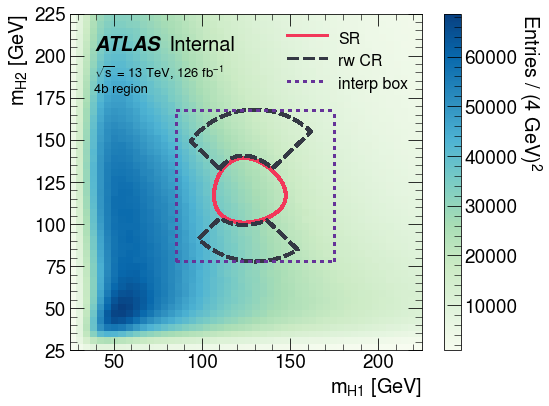

In [13]:
h_2d,ex,ey,_ = plt.hist2d(*df[['m_h1','m_h2']].values.T, [nbins,nbins],[r,r], cmap='GnBu')

cbar = plt.colorbar()

# Draw the SR + the rw
fig,ax = plt.gcf(), plt.gca()
draw_contours(ax, reg_dict, [ex[0],ex[-1]], [ey[0],ey[-1]])

draw_bounding_box(ax,xmin,xmax,ymin,ymax,kwargs)

plt.xlabel('$m_{H1}$ [GeV]',loc='right')
plt.ylabel('$m_{H2}$ [GeV]',loc='top')

cbar.set_label(zlabel,rotation=270,fontsize=20,y=1,ha='left',labelpad=25)

pas.makeATLAStag(ax, fig, first_tag=' Internal',
                 second_tag=r"$\sqrt{s}$ = 13 TeV, "+str(get_lumi('all'))+" fb$^{-1}$"+region_tag,
                 ymax=.88,xmin=.07,line_spacing=.2,
                 fontsize_title=20,fontsize_label=13)   

plt.legend(fontsize=16,labelspacing=0.2)

plt.savefig(f'figures/{subDir}/fullmassplane_all.png',bbox_inches='tight')
plt.savefig(f'figures/{subDir}/fullmassplane_all.pdf',bbox_inches='tight')

plt.show()

**Step 3:** Overlay the regions

For the 4b val_region, I'll go ahead + overlay the shifted region defs too.

In [14]:
SR_xs = [x,70,170,170,78]
SR_ys = [y,66,68, 166, 166]

In [15]:
colors=['hh:darkpink','hh:darkblue','darkorange','rebeccapurple','hh:darkgreen']

In [16]:
nbins = 50
r = (20,270)

w = (r[1] - r[0]) / nbins
zlabel = f'Entries / ({int(w)} GeV)$^2$'

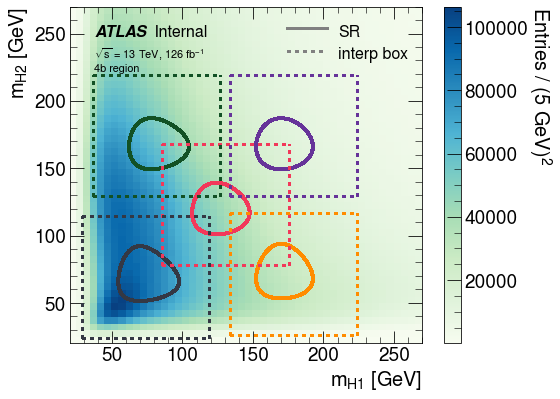

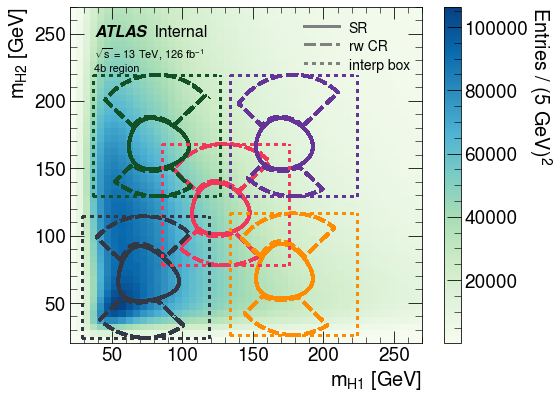

In [17]:
for show_rw in [False,True]:

    
    h_2d,ex,ey,_ = plt.hist2d(*df[['m_h1','m_h2']].values.T, [nbins,nbins],[r,r], cmap='GnBu')
    cbar = plt.colorbar()
    
    # Draw the SR + the rw
    fig,ax = plt.gcf(), plt.gca()


    for xi,yi,color_i in zip(SR_xs, SR_ys,colors):

        x_cr_i, y_cr_i = (xi*1.05, yi*1.05)

        xmin_i = x_cr_i - r_cr
        xmax_i = x_cr_i + r_cr
        ymin_i = y_cr_i - r_cr
        ymax_i = y_cr_i + r_cr

        res_x = 0.1 * 124 / xi
        res_y = 0.1 * 117 / yi

        reg_dict_i = {
            "SR": {
                "fn": "shiftXhh",
                "fn_args": {"center_x": xi, "center_y": yi, 
                            "res_x": res_x,"res_y":res_y},
                "bound": 1.6,
                "color": color_i, 
                "lw": lw,
                "ls": "solid",
                "label": None,
            },
            
        }
        
        if show_rw:
            reg_dict_i["CR"] = {"fn": "shiftCVR_q",
                                "fn_args": { "center_x": xi, "center_y": yi,
                                             "delta": 0.05, "angle": np.pi / 4.0, "qs": [0, 3],
                                            "res_x": res_x,"res_y":res_y},
                                "bound": 1,
                                "color": color_i, 
                                "lw": lw,
                                "ls": "dashed",
                                "label": None # "rw CR"
                               }

        kwargs['color'] = color_i
        draw_contours(ax, reg_dict_i, [ex[0],ex[-1]], [ey[0],ey[-1]])
        draw_bounding_box(ax,xmin_i,xmax_i,ymin_i,ymax_i,kwargs,label=None)

    plt.xlabel('$m_{H1}$ [GeV]',loc='right')
    plt.ylabel('$m_{H2}$ [GeV]',loc='top')

    cbar.set_label(zlabel,rotation=270,fontsize=20,y=1,ha='left',labelpad=25)

    pas.makeATLAStag(ax, fig, first_tag=' Internal',
                     second_tag=r"$\sqrt{s}$ = 13 TeV, "+str(get_lumi('all'))+" fb$^{-1}$"+region_tag,
                     ymax=.9,xmin=.07,line_spacing=.1,
                     fontsize_title=16,fontsize_label=11)   

    for ls,label in zip(['-','--','dotted'],['SR','rw CR','interp box']):
        if (ls == '--') and (not show_rw):
            continue
        plt.plot([],[],'grey',ls=ls,lw=lw,label=label)

    if show_rw:
        plt.legend(fontsize=14,labelspacing=0.1,loc='upper right')
        figname = 'fullmassplane_shift_regs_rw_all'
    else:
        plt.legend(fontsize=16,labelspacing=0.2,loc='upper right')
        figname = 'fullmassplane_shift_regs_all'
        
    plt.savefig(f'figures/{subDir}/{figname}.png',bbox_inches='tight')
    plt.savefig(f'figures/{subDir}/{figname}.pdf',bbox_inches='tight')

    plt.show()

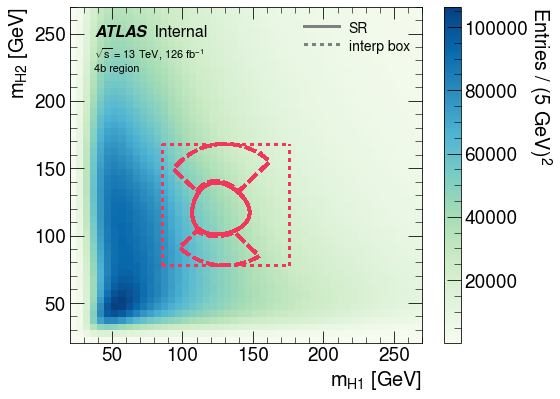

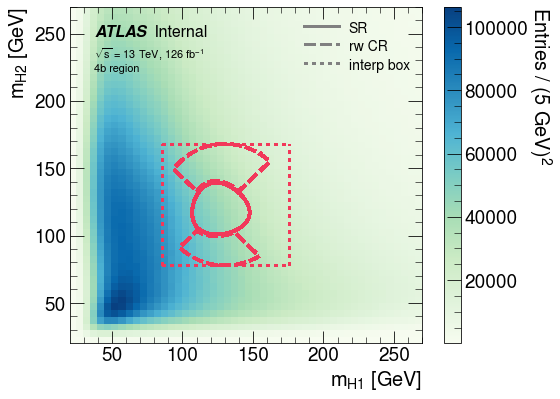

In [19]:
for show_rw in [False,True]:

    
    h_2d,ex,ey,_ = plt.hist2d(*df[['m_h1','m_h2']].values.T, [nbins,nbins],[r,r], cmap='GnBu')
    cbar = plt.colorbar()
    
    # Draw the SR + the rw
    fig,ax = plt.gcf(), plt.gca()

    xi = SR_xs[0]
    yi = SR_ys[0]
    color_i = colors[0]
    
    x_cr_i, y_cr_i = (xi*1.05, yi*1.05)

    xmin_i = x_cr_i - r_cr
    xmax_i = x_cr_i + r_cr
    ymin_i = y_cr_i - r_cr
    ymax_i = y_cr_i + r_cr

    res_x = 0.1 * 124 / xi
    res_y = 0.1 * 117 / yi

    reg_dict_i = {
        "SR": {
            "fn": "shiftXhh",
            "fn_args": {"center_x": xi, "center_y": yi, 
                        "res_x": res_x,"res_y":res_y},
            "bound": 1.6,
            "color": color_i, 
            "lw": lw,
            "ls": "solid",
            "label": None,
        },

    }

    
    reg_dict_i["CR"] = {"fn": "shiftCVR_q",
                        "fn_args": { "center_x": xi, "center_y": yi,
                                     "delta": 0.05, "angle": np.pi / 4.0, "qs": [0, 3],
                                    "res_x": res_x,"res_y":res_y},
                        "bound": 1,
                        "color": color_i, 
                        "lw": lw,
                        "ls": "dashed",
                        "label": None # "rw CR"
                       }

    kwargs['color'] = color_i
    draw_contours(ax, reg_dict_i, [ex[0],ex[-1]], [ey[0],ey[-1]])
    draw_bounding_box(ax,xmin_i,xmax_i,ymin_i,ymax_i,kwargs,label=None)

    plt.xlabel('$m_{H1}$ [GeV]',loc='right')
    plt.ylabel('$m_{H2}$ [GeV]',loc='top')

    cbar.set_label(zlabel,rotation=270,fontsize=20,y=1,ha='left',labelpad=25)

    pas.makeATLAStag(ax, fig, first_tag=' Internal',
                     second_tag=r"$\sqrt{s}$ = 13 TeV, "+str(get_lumi('all'))+" fb$^{-1}$"+region_tag,
                     ymax=.9,xmin=.07,line_spacing=.1,
                     fontsize_title=16,fontsize_label=11)   

    for ls,label in zip(['-','--','dotted'],['SR','rw CR','interp box']):
        if (ls == '--') and (not show_rw):
            continue
        plt.plot([],[],'grey',ls=ls,lw=lw,label=label)

    plt.legend(fontsize=14,labelspacing=0.1,loc='upper right')
    figname = 'fullmassplane_shift_regs_all_rw_all'

        
    plt.savefig(f'figures/{subDir}/{figname}_nomOnly.png',bbox_inches='tight')
    plt.savefig(f'figures/{subDir}/{figname}_nomOnly.pdf',bbox_inches='tight')

    plt.show()